# UVOD U ZNANOST O PODACIMA
## Projekt: Early-Stage Alzheimer's Disease Prediction Using Machine Learning Models
U ovom projektu bavimo se razvojem modela za predikcije rane faze Alzheimerove bolesti koristeći metode strojnog učenja.
Cilj projekta je replicirati rezultate postojećeg istraživačkog članka koji koristi strojno učenje za klasifikaciju i predikciju rane faze Alzheimerove bolesti.


In [1]:
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from pyparsing import Group
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from scipy import stats
import numpy as np

## Učitavanje podataka i prvi pogled na podatke


In [2]:
data = pd.read_csv('oasis_longitudinal.csv')
print(data.info())
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB
None


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039
8,OAS2_0005,OAS2_0005_MR2,Nondemented,2,1010,M,R,83,12,4.0,29.0,0.5,1701,0.711,1.032
9,OAS2_0005,OAS2_0005_MR3,Nondemented,3,1603,M,R,85,12,4.0,30.0,0.0,1699,0.705,1.033


## Priprema podataka
Prije samog čišćenja podataka potrebno je pripremiti podatke tj. grupirati pacijente te za svakog pacijenta koji ima više od jednog posjeta, uzeti samo prvi posjet kako daljnja analiza i izračunate statistike nebi bile pristrane za pacijente koji imaju više posjeta.

In [4]:
print(f"----Broj redaka sa svim posjetama: {data.shape[0]}----")
data = data.sort_values(by='Visit', ascending=True)
data = data.groupby('Subject ID').first().reset_index()
print(f"----Broj redaka samo sa prvim posjetama: {data.shape[0]}----")

data

----Broj redaka sa svim posjetama: 373----
----Broj redaka samo sa prvim posjetama: 150----


,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
2,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
3,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039
4,OAS2_0007,OAS2_0007_MR1,Demented,1,0,M,R,71,16,NaN,28.0,0.5,1357,0.748,1.293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,OAS2_0182,OAS2_0182_MR1,Demented,1,0,M,R,73,12,NaN,23.0,0.5,1661,0.698,1.056
146,OAS2_0183,OAS2_0183_MR1,Nondemented,1,0,F,R,66,13,2.0,30.0,0.0,1495,0.746,1.174
147,OAS2_0184,OAS2_0184_MR1,Demented,1,0,F,R,72,16,3.0,24.0,0.5,1354,0.733,1.296
148,OAS2_0185,OAS2_0185_MR1,Demented,1,0,M,R,80,16,1.0,28.0,0.5,1704,0.711,1.030


## Čišćenje podataka
Prije prikazivanja pojedinih statistika o podacima, pronaći ćemo monotone i konstantne vrijednosti te ih ukloniti kako nebi nepotrebno smetali pri analizi podataka. Također osim monotonih i konstantnih podataka provest ćemo i zamjenu/uklanjanje nedostajućih vrijednosti s određenim postupkom za konkretan stupac.
### Pronalazak i uklanjanje konstantnih i monotonih vrijednosti

In [5]:
print(f"----Broj redaka: {data.shape[0]}----")
print(data.nunique())

----Broj redaka: 150----
Subject ID    150
MRI ID        150
Group           3
Visit           1
MR Delay        1
M/F             2
Hand            1
Age            34
EDUC           12
SES             5
MMSE           13
CDR             3
eTIV          131
nWBV           90
ASF           129
dtype: int64


Prethodnim ispisom možemo zaključiti da su stupci Subject ID i MRI ID monotoni i nemamo koristi od njih jer svaki redak ima jedinstvenu vrijednost, također možemo zaključiti da su stupci Visit, MR Delay, Hand konstantni budući da svaki redak ima jednaku vrijednost stoga izbacujemo navedene stupce.


In [6]:
data.drop(['Subject ID', 'MRI ID', 'Visit', 'MR Delay', 'Hand'], axis=1, inplace=True)
data

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Demented,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
2,Nondemented,F,88,18,3.0,28.0,0.0,1215,0.710,1.444
3,Nondemented,M,80,12,4.0,28.0,0.0,1689,0.712,1.039
4,Demented,M,71,16,NaN,28.0,0.5,1357,0.748,1.293
...,...,...,...,...,...,...,...,...,...,...
145,Demented,M,73,12,NaN,23.0,0.5,1661,0.698,1.056
146,Nondemented,F,66,13,2.0,30.0,0.0,1495,0.746,1.174
147,Demented,F,72,16,3.0,24.0,0.5,1354,0.733,1.296
148,Demented,M,80,16,1.0,28.0,0.5,1704,0.711,1.030


### Zamjena/uklanjanje nedostajućih vrijednosti s određenim postupkom
Pretražujemo stupce/varijable na kojima imamo nedostajuće vrijednosti.

In [7]:
print("Broj nedostajućih vrijednosti po stupcima:\n")
missing_values = data.isnull().sum()
print(missing_values)

Broj nedostajućih vrijednosti po stupcima:

Group    0
M/F      0
Age      0
EDUC     0
SES      8
MMSE     0
CDR      0
eTIV     0
nWBV     0
ASF      0
dtype: int64


Nakon uzimanja konteksta stupca u obzir, nedostajuće vrijednosti zamjenjujemo medijanom kako bi bile iz domene vrijednosti podataka u stupcu (npr. SES nema smisla da postavimo kao decimalan broj srednje vrijednosti jer su SES vrijednosti cijeli brojevi od 1 do 5)

In [8]:
data.loc[data.SES.isna(), 'SES'] = data.loc[:, 'SES'].median()
data

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Demented,M,75,12,2.0,23.0,0.5,1678,0.736,1.046
2,Nondemented,F,88,18,3.0,28.0,0.0,1215,0.710,1.444
3,Nondemented,M,80,12,4.0,28.0,0.0,1689,0.712,1.039
4,Demented,M,71,16,2.0,28.0,0.5,1357,0.748,1.293
...,...,...,...,...,...,...,...,...,...,...
145,Demented,M,73,12,2.0,23.0,0.5,1661,0.698,1.056
146,Nondemented,F,66,13,2.0,30.0,0.0,1495,0.746,1.174
147,Demented,F,72,16,3.0,24.0,0.5,1354,0.733,1.296
148,Demented,M,80,16,1.0,28.0,0.5,1704,0.711,1.030


## Pretvorba kategorijskih podataka u numeričke
Prije same pretvorbe kategorijskih podataka u numeričke ugrubo ćemo prikazati osnovne statistike: srednju (mean), centralnu (median), minimalnu i maksimalnu vrijednost za numeričke podatke, te učestalost pojavljivanja svake vrijednosti za kategorijske podatke.

In [9]:
# prikaz numerickih podataka
print("----NUMERICKI PODACI----")
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()
print(data.loc[:, numerical_columns].agg(['mean', 'median', 'max', 'min']))

# prikaz ucestalosti pojavljivanja svake vrijednosti
print("----KATEGORIJSKI PODACI----")
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
for column in categorical_columns:
    print("---------------")
    print(data.loc[:, column].value_counts())

----NUMERICKI PODACI----
              Age       EDUC       SES   MMSE   CDR         eTIV      nWBV  \
mean    75.446667  14.533333  2.466667  27.56  0.26  1474.426667  0.736073   
median  75.000000  14.000000  2.000000  29.00  0.00  1453.500000  0.735000   
max     96.000000  23.000000  5.000000  30.00  1.00  1987.000000  0.837000   
min     60.000000   6.000000  1.000000  17.00  0.00  1123.000000  0.660000   

             ASF  
mean    1.206333  
median  1.207500  
max     1.563000  
min     0.883000  
----KATEGORIJSKI PODACI----
---------------
Group
Nondemented    72
Demented       64
Converted      14
Name: count, dtype: int64
---------------
M/F
F    88
M    62
Name: count, dtype: int64


In [10]:
encoder = LabelEncoder()
group_mapping = {'Nondemented': 0, 'Demented': 1, 'Converted': 2}
data['Group'] = data['Group'].map(group_mapping)
data['Group'] = data['Group'].replace(2, 1)
print("Mapiranje za varijablu Group:")
print(group_mapping)


data['M/F'] = encoder.fit_transform(data['M/F'])
print("Mapiranje za varijablu M/F:")
print(dict(zip(encoder.classes_, range(len(encoder.classes_)))))

data

Mapiranje za varijablu Group:
{'Nondemented': 0, 'Demented': 1, 'Converted': 2}
Mapiranje za varijablu M/F:
{'F': 0, 'M': 1}


,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,1,1,75,12,2.0,23.0,0.5,1678,0.736,1.046
2,0,0,88,18,3.0,28.0,0.0,1215,0.710,1.444
3,0,1,80,12,4.0,28.0,0.0,1689,0.712,1.039
4,1,1,71,16,2.0,28.0,0.5,1357,0.748,1.293
...,...,...,...,...,...,...,...,...,...,...
145,1,1,73,12,2.0,23.0,0.5,1661,0.698,1.056
146,0,0,66,13,2.0,30.0,0.0,1495,0.746,1.174
147,1,0,72,16,3.0,24.0,0.5,1354,0.733,1.296
148,1,1,80,16,1.0,28.0,0.5,1704,0.711,1.030


Prethodnim prikazom vidimo kako su jedine kategorijske varijable Group (koja je ujedno i ciljna varijabla) i M/F (koja predstavlja spol). Sljedeći korak je pretvorba navednih kategorijskih varijabli u numeričke vrijednosti. Neuređene kategorije tj. kategoričke varijable koje nemaju smisleni poredak spadaju u kategoriju nominalnih podataka te za njih koristimo one-hot encoding (svaka kategorija odvaja se u zasebni stupac) za pretvorbu.
Uređene kategorije tj. kategoričke varijable koje imaju smisleni poredak (loše, dobro, odlično) spadaju u kategoriju ordinalnih podataka te za njih koristimo label encoding (svaka kategorija ostaje u istom stupcu samo su drugčije mapirane npr. kodovima 1, 2, 3).
Naše kategorijske varijable su uređene pa stoga koristimo label encoding.

## Izbacivanje stršećih vrijednosti
Za izbacivanje stršećih vrijednosti koristit ćemo metodu Z-score koja mjeri koliko je svaka vrijednost udaljena od srednje vrijednosti u jedinicama standardne devijacije.

Prije samog postupka izbacivanja prikazat ćemo stršeće podatke box plot dijagramom.

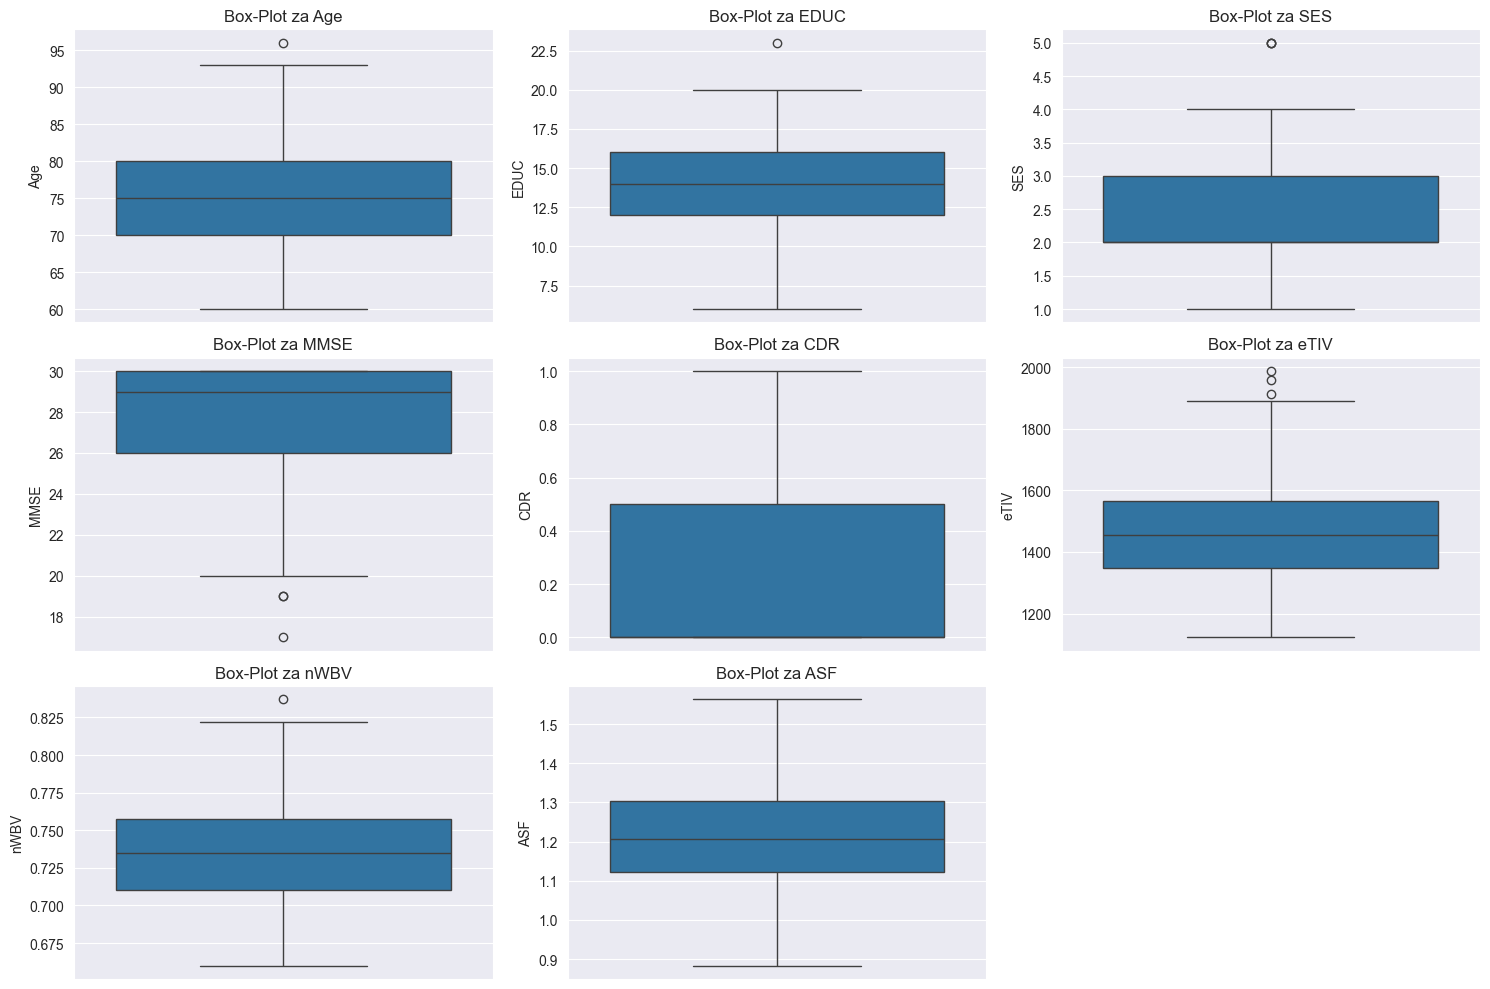

In [11]:
numeric_columns = data.select_dtypes(include=['number']).columns.drop(['M/F', 'Group'])

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot((len(numeric_columns) + 2) // 3, 3, i)
    sns.boxplot(y=data[column])
    plt.title(f"Box-Plot za {column}")
    plt.ylabel(column)
    plt.tight_layout()

plt.show()

### Postupak izbacivanja stršećih vrijednosti

In [3]:
print(f"----Broj redaka prije izbacivanja stršećih vrijednosti: {data.shape[0]}----")
z_scores = np.abs(stats.zscore(data.select_dtypes(include=['number'])))
data = data[(z_scores < 3).all(axis=1)] 
print(f"----Broj redaka nakon izbacivanja stršećih vrijednosti: {data.shape[0]}----")

----Broj redaka prije izbacivanja stršećih vrijednosti: 373----
----Broj redaka nakon izbacivanja stršećih vrijednosti: 0----


## Pogled osnovnih statistika nakon kompletne pripreme i čišćenja podataka

In [13]:
data.describe()

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,0.516779,0.409396,75.536913,14.550336,2.456376,27.630872,0.258389,1474.087248,0.736101,1.206705
std,0.501404,0.493381,7.489203,2.876833,1.099651,2.848302,0.326757,175.223407,0.036580,0.138254
min,0.000000,0.000000,60.000000,6.000000,1.000000,19.000000,0.000000,1123.000000,0.660000,0.883000
25%,0.000000,0.000000,70.000000,12.000000,2.000000,26.000000,0.000000,1346.000000,0.710000,1.119000
50%,1.000000,0.000000,75.000000,14.000000,2.000000,29.000000,0.000000,1453.000000,0.736000,1.208000
75%,1.000000,1.000000,80.000000,16.000000,3.000000,30.000000,0.500000,1568.000000,0.758000,1.304000
max,1.000000,1.000000,96.000000,23.000000,5.000000,30.000000,1.000000,1987.000000,0.837000,1.563000


## Normalizacija podataka
Normalizirane podatke spremit ćemo u kopiju varijable data, budući da ćemo za vizualizaciju koristiti podatke koji nisu normalizirani. Koristimo MinMaxScaler koji koristi linearnu transformaciju vrijednosti na raspon 0-1 sljedećom formulom: x_normalized = (x – min) / (max – min)

In [14]:
data_normalized = data.copy()
scaler = MinMaxScaler()
numerical_columns = data_normalized.select_dtypes(include=['number']).columns.tolist()
data_normalized[numerical_columns] = scaler.fit_transform(data_normalized[numerical_columns])

data_normalized

,Group,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0.0,1.0,0.750000,0.470588,0.25,0.727273,0.0,1.000000,0.203390,0.000000
1,1.0,1.0,0.416667,0.352941,0.25,0.363636,0.5,0.642361,0.429379,0.239706
2,0.0,0.0,0.777778,0.705882,0.50,0.818182,0.0,0.106481,0.282486,0.825000
3,0.0,1.0,0.555556,0.352941,0.75,0.818182,0.0,0.655093,0.293785,0.229412
4,1.0,1.0,0.305556,0.588235,0.25,0.818182,0.5,0.270833,0.497175,0.602941
...,...,...,...,...,...,...,...,...,...,...
145,1.0,1.0,0.361111,0.352941,0.25,0.363636,0.5,0.622685,0.214689,0.254412
146,0.0,0.0,0.166667,0.411765,0.25,1.000000,0.0,0.430556,0.485876,0.427941
147,1.0,0.0,0.333333,0.588235,0.50,0.454545,0.5,0.267361,0.412429,0.607353
148,1.0,1.0,0.555556,0.588235,0.00,0.818182,0.5,0.672454,0.288136,0.216176


## Vizualizacija podataka nakon čišćenja

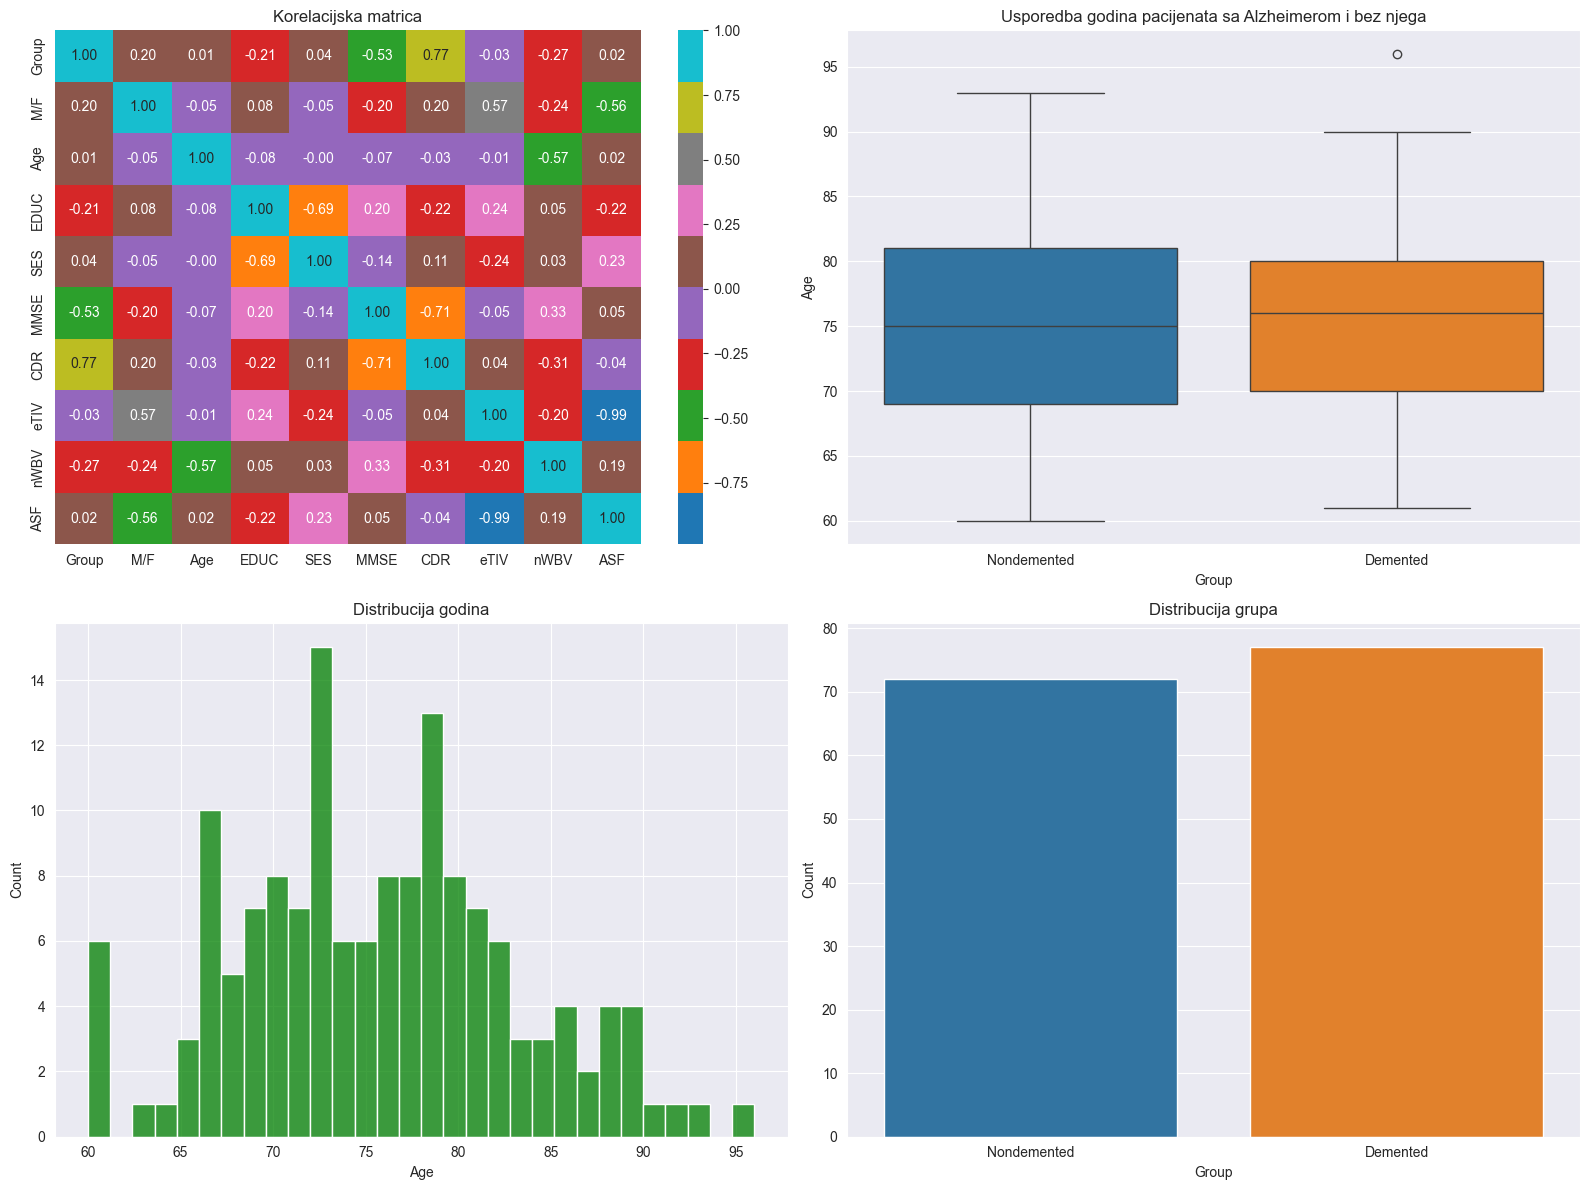

In [15]:
visualization_data = data.copy()
visualization_data['Group'] = visualization_data['Group'].replace({0: 'Nondemented', 1: 'Demented'})

numerical_columns = visualization_data.select_dtypes(include=['number']).columns.tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.heatmap(data.corr(), annot=True, cmap='tab10', fmt=".2f", ax=axes[0, 0])
axes[0, 0].set_title("Korelacijska matrica")

sns.boxplot(data=visualization_data, x='Group', y='Age', ax=axes[0, 1], palette='tab10', hue='Group')
axes[0, 1].set_title('Usporedba godina pacijenata sa Alzheimerom i bez njega')
axes[0, 1].set_xlabel('Group')
axes[0, 1].set_ylabel('Age')

sns.histplot(visualization_data['Age'], bins=30, ax=axes[1, 0], color='green')
axes[1, 0].set_title('Distribucija godina')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Count')

sns.countplot(data=visualization_data, x='Group', palette='tab10', ax=axes[1, 1], hue='Group')
axes[1, 1].set_title('Distribucija grupa')
axes[1, 1].set_xlabel('Group')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

#### Zaključak grafova
Boxplot usporedbe godina između grupa (gornji desni graf): Ovaj graf uspoređuje raspodjelu godina između dvije grupe: Nondemented (bez demencije) i Demented (s demencijom).
Grupa s demencijom općenito ima nešto nižu srednju vrijednost godina.
Vidljivo je nekoliko "outlier" vrijednosti, posebno kod grupe bez demencije.
Raspon godina je sličan u obje grupe, ali varijacije su nešto veće kod grupe bez demencije.

Distribucija godina (donji lijevi graf): Ovaj histogram prikazuje učestalost pojedinih dobnih skupina u skupu podataka.
Većina uzoraka pripada dobnim skupinama između 70 i 80 godina.
Manje je uzoraka u krajnjim dobnim skupinama, posebno kod osoba mlađih od 65 ili starijih od 85 godina.

Distribucija grupa (donji desni graf): Ovaj stupčasti graf prikazuje broj ispitanika u svakoj od dvije grupe:
Nondemented i Demented.
Grupa s demencijom ima nešto više uzoraka u odnosu na grupu bez demencije.

Prikazani grafovi nastali su iz usporedbe različitih varijabli u skupu podataka s ciljem razumijevanja njihovih međusobnih odnosa. Na grafovima se svaka točka odnosi na jednog ispitanika, dok je boja točke povezana s pripadnošću grupi (Nondemented ili Demented).

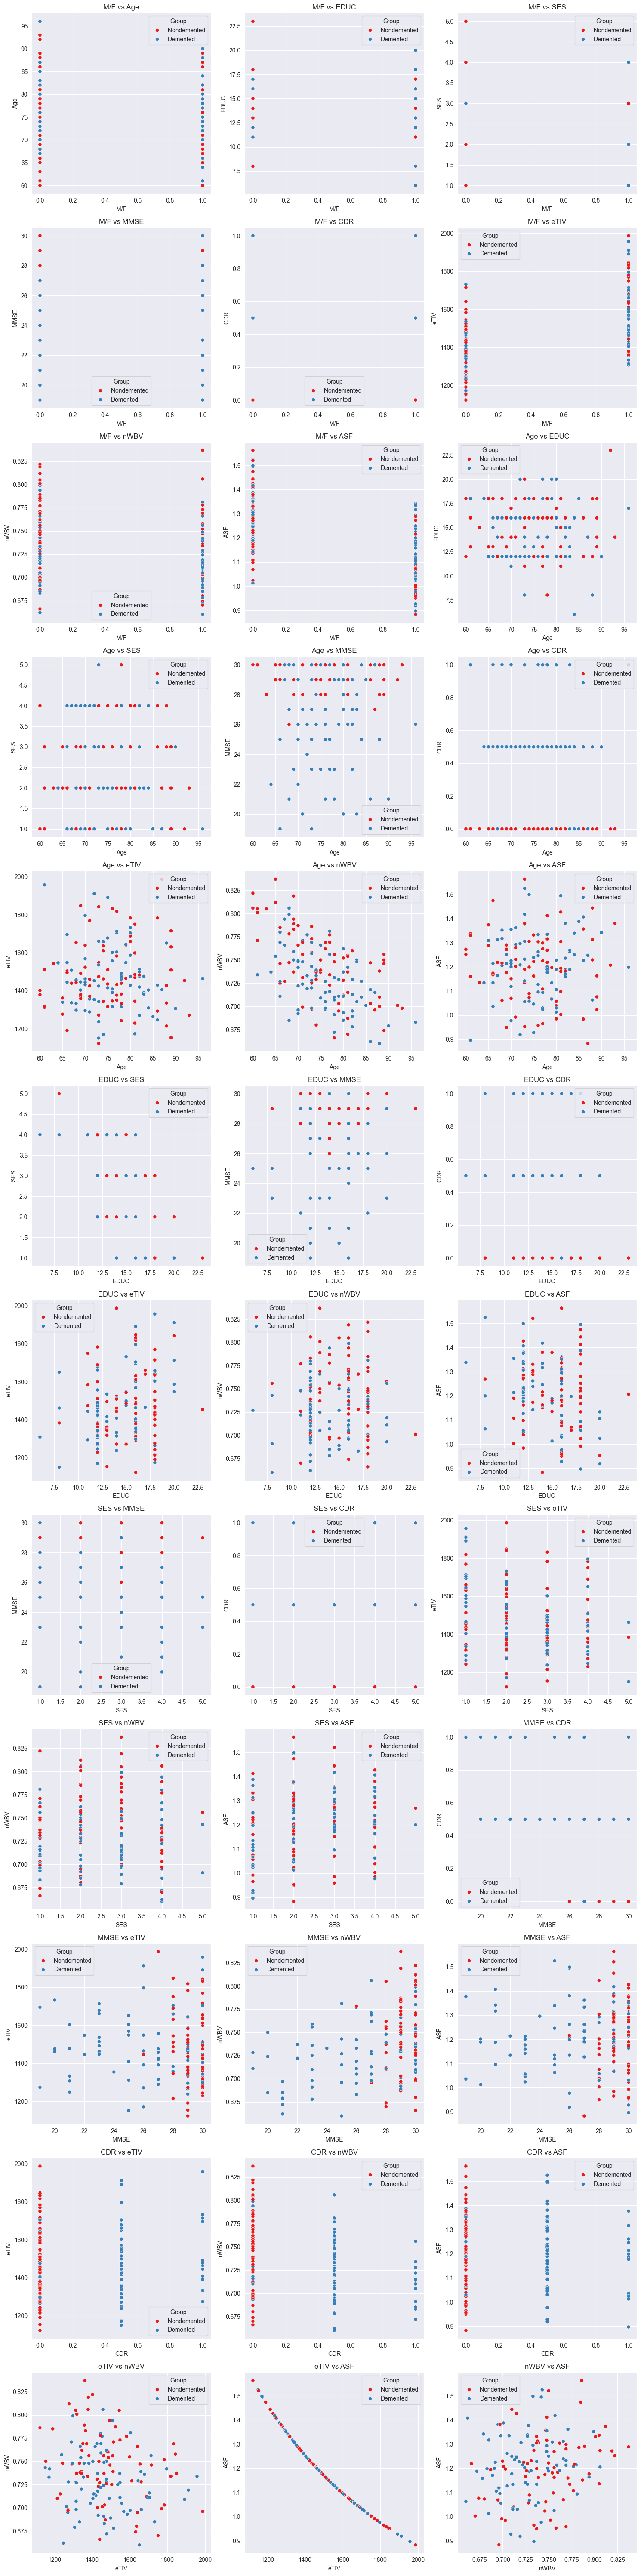

In [16]:
variables = [col for col in visualization_data.columns if col != 'Group']
variable_combinations = list(combinations(variables, 2))

n_plots = len(variable_combinations)
n_cols = 3
n_rows = math.ceil(n_plots / n_cols)

fig_, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), squeeze=False)

for ax, (var1, var2) in zip(axes.flatten(), variable_combinations):
    sns.scatterplot(data=visualization_data, x=var1, y=var2, hue='Group', palette='Set1', ax=ax)
    ax.set_title(f'{var1} vs {var2}')
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)

for ax in axes.flatten()[len(variable_combinations):]:
    ax.remove()

plt.tight_layout()
plt.show()

#### Zaključak grafova

Svaki scatter plot prikazuje odnos između dvije varijable (npr. MF vs Age, MF vs EDUC, itd.).
Na x-osi je jedna varijabla, a na y-osi druga.
Cilj je otkriti postoji li vidljiva povezanost između tih varijabli i razlika među grupama.

Boje točaka:

Crvena boja predstavlja grupu Nondemented (osobe bez demencije).
Plava boja predstavlja grupu Demented (osobe s demencijom).

Distribucija i uzorci:

U većini grafova točke se čine jasno razdvojene ili grupirane u određene regije, ovisno o vrijednostima varijabli.
Pojedine varijable, poput MF (muško/žensko), imaju diskretne vrijednosti, dok su druge, poput Age ili eTIV, kontinuirane.
Naslov svakog grafa:

Svaki graf ima naslov u formatu "Var1 vs Var2", što olakšava identifikaciju koje dvije varijable se uspoređuju.

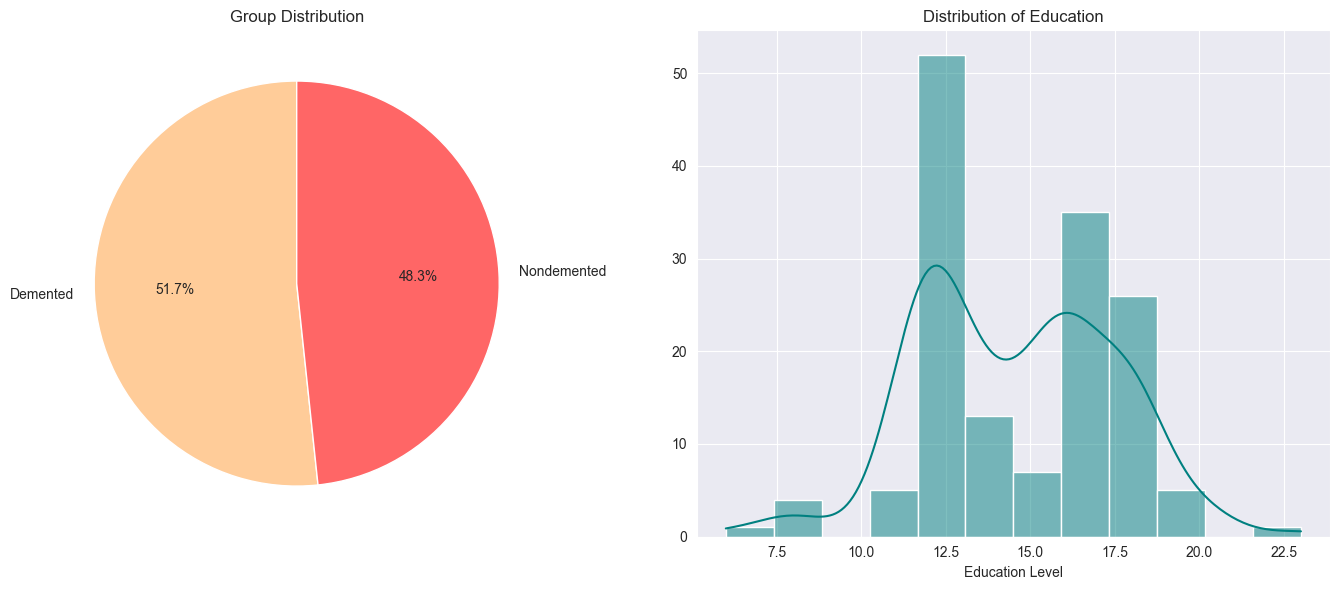

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
group_counts = visualization_data['Group'].value_counts()
group_labels = group_counts.index.tolist()  
axes[0].pie(group_counts, labels=group_labels, autopct='%1.1f%%', startangle=90, 
            colors=['#ffcc99', '#ff6666', '#66b3b3'])
axes[0].set_title('Group Distribution')

sns.histplot(visualization_data['EDUC'], kde=True, ax=axes[1], color='teal')
axes[1].set_title('Distribution of Education')
axes[1].set_xlabel('Education Level')
axes[1].set_ylabel(None) 

plt.tight_layout()
plt.show()



#### Zaključak grafova

Pie Chart - "Group Distribution":

Ovaj grafikon prikazuje distribuciju grupa u podacima:
Demented (51.7%): Osobe s dijagnozom demencije.
Nondemented (48.3%): Osobe bez dijagnoze demencije.
Graf omogućuje brzu vizualizaciju ravnomjernosti raspodjele između dviju grupa. Distribucija je približno jednaka, što osigurava balansirane podatke za analizu.

Histogram - "Distribution of Education":

Histogram prikazuje distribuciju razine obrazovanja (EDUC) među ispitanicima.
Većina ispitanika ima obrazovanje na razini između 12 i 15 godina, što odgovara srednjoj i višoj školi.
Gustoća (kde) linija pokazuje oblik distribucije, gdje se uočavaju dva dominantna vrha, što može upućivati na heterogenost u obrazovnim razinama među grupama.

## Replikacija rezultata
U ovom dijelu projekta fokusiramo se na replikaciju rezultata istraživanja predstavljenog u članku. Cilj ove replikacije je provjera vjerodostojnosti i ponovljivosti dobivenih rezultata korištenjem istih metoda i skupa podataka. Time osiguravamo osnovu za daljnju analizu i unapređenje postojećih modela.


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

#### Budući da prema koeficijentima korelacije koji slijede varijable Group i CDR imaju jako veliku međusobnu korelaciju, izbacujemo varijablu CDR zato što ona zapravo predstavlja kliničku razinu demencije. 

In [19]:
correlation = data[['CDR', 'Group']].corr(method='spearman')
print(correlation)
data = data.drop(['CDR'], axis=1).copy()

           CDR    Group
CDR    1.00000  0.81794
Group  0.81794  1.00000


#### Na priloženom grafu vidimo da muškarci imaju veću vjerojatnost da će imati demenciju nego žene

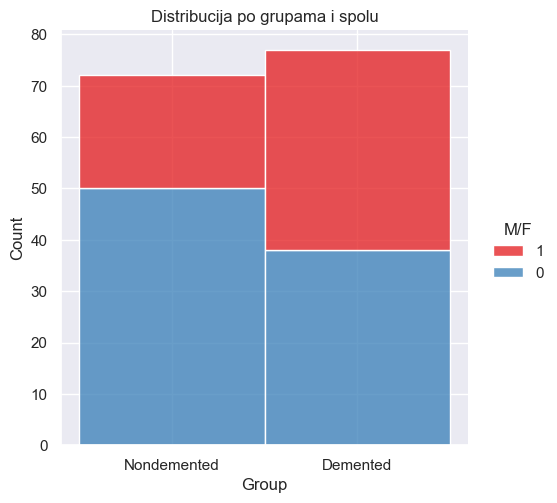

In [20]:
sns.set_theme(rc={'figure.figsize': (8,6)})
sns.displot(
    data=visualization_data, 
    x="Group", 
    hue="M/F", 
    multiple="stack", 
    palette="Set1", 
    hue_order=[1, 0]
)

plt.xlabel("Group")
plt.title("Distribucija po grupama i spolu")
plt.show()

#### Analiza MMSE rezultata za dementnu i nedementnu skupinu bolesnika

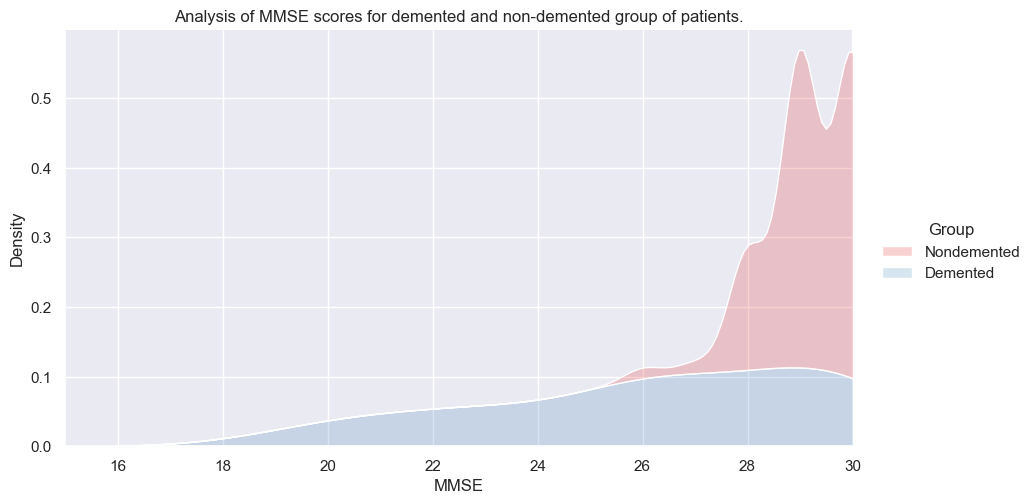

In [21]:
sns.set_theme(rc={'figure.figsize':(10,20)})
sns.displot(data=visualization_data, x="MMSE", hue="Group", multiple="stack", kind="kde", fill=True, common_norm=False, alpha=0.2, palette="Set1", height=5, aspect=16/9)
plt.title("Analysis of MMSE scores for demented and non-demented group of patients.")
plt.xlim(15, 30)
plt.show()

#### Nedementni pacijenti (crvena boja)

Imaju veću gustoću rezultata u opsegu 27-30, što znači da većina nedementnih pacijenata postiže visoke MMSE rezultate. Očigledan vrhunac (povećana gustoća) blizu 30 sugerira da su ovi pacijenti kognitivno zdravi.

#### Dementni pacijenti (plava boja)

Imaju niže MMSE rezultate, najviše u opsegu 16-26. Gustoća raste između 20 i 25, što sugerira da većina dementnih pacijenata ima kognitivno oštećenje prema MMSE testu. Praktično ne postoji plavi segment iznad 27-28, što znači da dementni pacijenti rijetko postižu visoke rezultate na testu.

#### Analiza ASF, eTIV i nWBV za skupinu dementnih i nedementnih

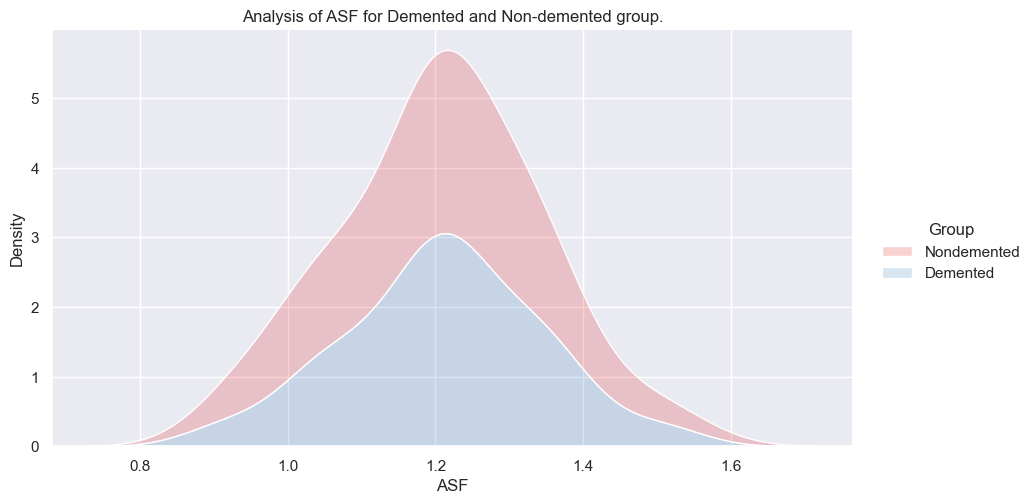

In [22]:
sns.set_theme(rc={'figure.figsize':(10,20)})
sns.displot(data=visualization_data, x="ASF", hue="Group", multiple="stack", kind="kde", fill=True, common_norm=False, alpha=0.2, palette="Set1", height=5, aspect=16/9)
plt.title("Analysis of ASF for Demented and Non-demented group.")
plt.show()

#### Distribucija ASF kod nedementnih pacijenata (crvena boja)

Nedementni pacijenti imaju više vrijednosti ASF-a, s najvećom gustoćom oko 1.2 - 1.3. Većina nedementnih pacijenata ima ASF u opsegu od 1.0 do 1.5, uz manji broj vrijednosti izvan tog raspona. Njihova distribucija je šira, što ukazuje na veću varijabilnost u ASF vrijednostima.

#### Distribucija ASF kod dementnih pacijenata (plava boja)

Dementni pacijenti generalno imaju niže ASF vrijednosti nego nedementni. Distribucija je pomaknuta ka nižim vrijednostima (~0.9 - 1.3), s manjom gustoćom na višim vrijednostima. Postoji jasna razlika između grupa, ali i preklapanje, što znači da ASF samostalno nije apsolutni indikator demencije.

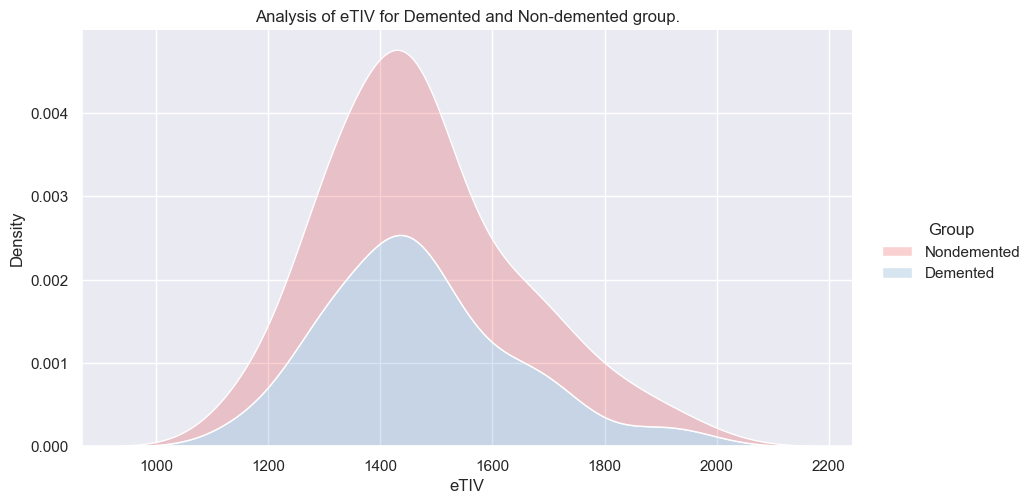

In [23]:
sns.set_theme(rc={'figure.figsize':(10,20)})
sns.displot(data=visualization_data, x="eTIV", hue="Group", multiple="stack", kind="kde", fill=True, common_norm=False, alpha=0.2, palette="Set1", height=5, aspect=16/9)
plt.title("Analysis of eTIV for Demented and Non-demented group.")
plt.show()

#### Distribucija eTIV kod nedementnih pacijenata (crvena boja)

Nedementni pacijenti imaju širi raspon eTIV vrijednosti, s najvećom gustoćom oko 1400-1500. Njihove eTIV vrijednosti su u prosjeku više od onih kod dementnih pacijenata, ali postoji značajno preklapanje. Distribucija se prostire do većih volumena (>1800-2000), što sugerira da su veći intrakranijalni volumeni češći kod nedementnih osoba.

#### Distribucija eTIV kod dementnih pacijenata (plava boja)

Dementni pacijenti generalno imaju niže eTIV vrijednosti, s vrhom distribucije oko 1300-1400. Njihov raspon eTIV-a ne prelazi često 1800, što može ukazivati na to da manji intrakranijalni volumen može biti povezan s demencijom. Ipak, postoji značajno preklapanje između grupa, što znači da eTIV sam po sebi nije dovoljan za preciznu dijagnozu demencije.

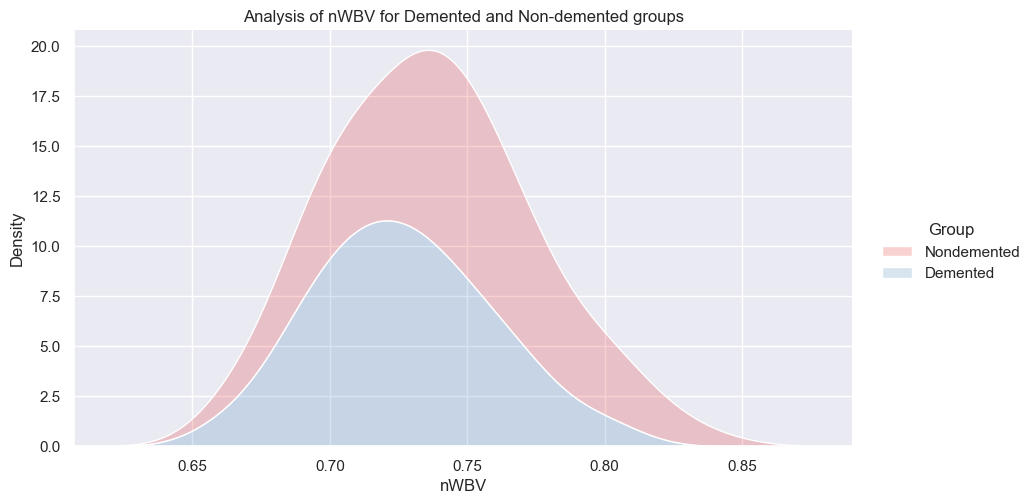

In [24]:
sns.set_theme(rc={'figure.figsize':(10,20)})
sns.displot(data=visualization_data, x="nWBV", hue="Group", multiple="stack", kind="kde", fill=True, common_norm=False, alpha=0.2, palette="Set1", height=5, aspect=16/9)
plt.title('Analysis of nWBV for Demented and Non-demented groups')
plt.show()

#### Distribucija nWBV kod nedementnih pacijenata (crvena boja)

Nedementni pacijenti generalno imaju veće vrijednosti nWBV, s najvećom gustoćom između 0.72 i 0.78. To znači da većina nedementnih pacijenata ima veći ukupni volumen mozga u odnosu na intrakranijalni prostor, što je očekivano kod zdravih osoba. Njihove nWBV vrijednosti sežu do 0.85, što sugerira da osobe s većim volumenom mozga rjeđe pate od demencije.

#### Distribucija nWBV kod dementnih pacijenata (plava boja)

Dementni pacijenti imaju niže nWBV vrijednosti, s distribucijom koja se više pomiče prema nižim vrijednostima (0.68 - 0.74). To može ukazivati na atrofiju mozga, koja je karakteristična za neurodegenerativne bolesti poput ove bolesti. Preklapanje između grupa postoji, ali je jasno da dementni pacijenti imaju tendenciju ka nižim nWBV vrijednostima.

#### Analiza godina obrazovanja za skupinu dementnih i nedementnih

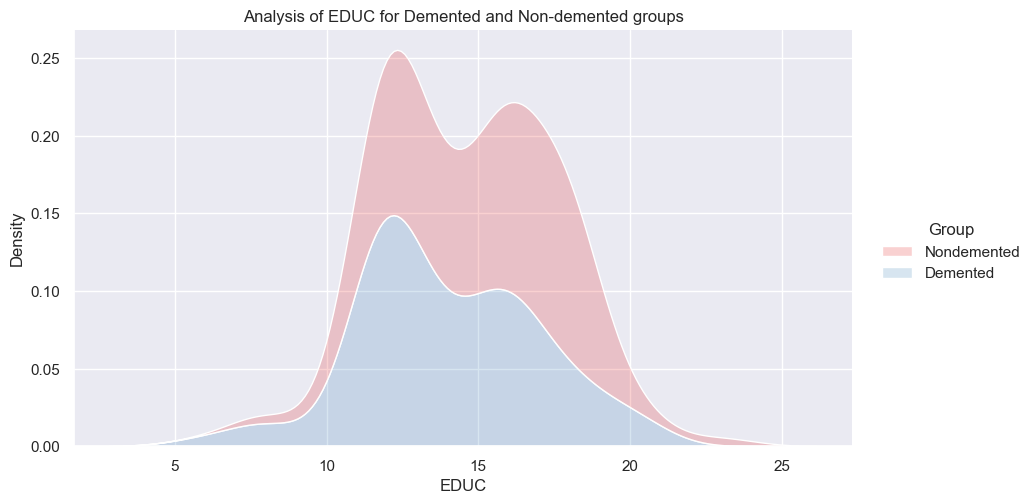

In [25]:
sns.set_theme(rc={'figure.figsize':(10,20)})
sns.displot(data=visualization_data, x="EDUC", hue="Group", multiple="stack", kind="kde", fill=True, common_norm=False, alpha=0.2, palette="Set1", height=5, aspect=16/9)
plt.title('Analysis of EDUC for Demented and Non-demented groups')
plt.show()

#### Distribucija EDUC kod nedementnih pacijenata (crvena boja)

Većina nedementnih pacijenata ima 12-16 godina obrazovanja, s najvećom gustoćom oko 13-15 godina. Postoji i značajan broj pacijenata s više od 16 godina obrazovanja, što može ukazivati na to da više obrazovanje može pružiti određenu zaštitu od demencije.

#### Distribucija EDUC kod dementnih pacijenata (plava boja)

Dementni pacijenti imaju niže vrijednosti obrazovanja, s vrhom distribucije između 10 i 14 godina. Manji broj dementnih pacijenata ima više od 16 godina obrazovanja, što može značiti da viši nivo obrazovanja može smanjiti rizik ili odgoditi početak demencije. Distribucija pokazuje da postoji preklapanje između grupa, ali se može primijetiti jasan trend da nedementni pacijenti češće imaju više obrazovanja.

#### Analiza osoba pogođenih dementnom i nedementnom skupinom na temelju dobi

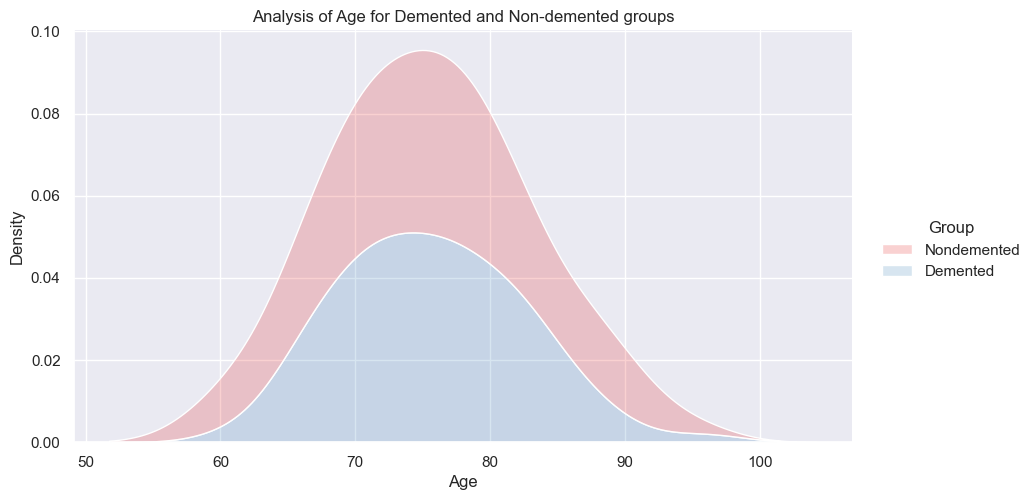

In [26]:
sns.set_theme(rc={'figure.figsize':(10,20)})
sns.displot(data=visualization_data, x="Age", hue="Group", multiple="stack", kind="kde", fill=True, common_norm=False, alpha=0.2, palette="Set1", height=5, aspect=16/9)
plt.title('Analysis of Age for Demented and Non-demented groups')
plt.show()

#### Distribucija dobi kod nedementnih pacijenata (crvena boja)

Većina nedementnih pacijenata se nalazi između 65 i 80 godina, s najvećom gustoćom oko 72-75 godina. Postoje pojedinci stariji od 90 godina koji još uvijek nisu razvili demenciju, što može ukazivati na genetske ili životne faktore koji pomažu u očuvanju kognitivnih funkcija.

#### Distribucija dobi kod dementnih pacijenata (plava boja)

Dementni pacijenti su uglavnom stariji, s distribucijom koncentrisanom između 70 i 85 godina, dok je vrhunac gustoće između 75 i 80 godina. Broj dementnih pacijenata opada nakon 85. godine, što može biti posljedica kraćeg životnog vijeka kod oboljelih ili manjeg broja dostupnih podataka za vrlo stare pacijente.

#### Usporedba grupa

Dementni pacijenti su u prosjeku stariji od nedementnih, što potvrđuje da je dob jedan od glavnih faktora rizika za demenciju. Međutim, postoje stariji pojedinci (80+) koji nisu dementni, što sugerira da dob nije jedini faktor, već da drugi faktori (genetika, stil života, obrazovanje, zdravlje) igraju važnu ulogu. Preklapanje između grupa pokazuje da neki ljudi mogu razviti demenciju prije ili kasnije u životu, ovisno o individualnim faktorima.

## Evaluacija modela 
U ovom poglavlju analiziraju se različiti modeli strojnog učenja koji su korišteni u poglavlju replikacije za predikciju i klasifikaciju Alzheimerove bolesti, te se procjenjuje njihova učinkovitost na temelju odabranih metrika evaluacije. Cilj ovog poglavlja je pružiti detaljan pregled performansi modela kako bi se usporedili dobiveni rezultati sa onima u članku.

In [27]:
X = data.drop(['Group'], axis=1)
y = data['Group']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifiers = [
    "Decision tree classifier",
    "Random forest classifier",
    "Support vector machine",
    "XGBoost",
    "Voting classifier"
]

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
df = pd.DataFrame(0.0, index=classifiers, columns=metrics)

def print_scores(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
    f1_res = f1_score(y_true, y_pred, average='weighted', zero_division=1)
    df.loc[model_name] = [accuracy, precision, recall, f1_res]

    print(f"\nEvaluacija modela: {model_name}")
    print("=" * 50)
    print(f"-> Accuracy:  {accuracy*100:.2f}%")
    print(f"-> Precision: {precision:.4f}")
    print(f"-> Recall:    {recall:.4f}")
    print(f"-> F1 Score:  {f1_res:.4f}")

def print_graphs(y_true, y_pred, model, model_name):
    plt.figure(figsize=(20, 5))
    confusion_mat = confusion_matrix(y_true, y_pred)
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr)
    plt.title("AUC/ROC krivulja")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

## DECISION TREE CLASSIFIER
Decision Tree je jednostavan, interpretabilan model koji donosi odluke dijeleći podatke na podskupove na osnovu značajki. Ovaj model je često sklon overfittingu, ali može biti vrlo efikasan kada se koristi pravilno ili u kombinaciji s drugim modelima (npr. Random Forest). Brz je za treniranje i obično pruža dobru interpretabilnost.

Testiranje preciznosti decision tree classifier modela:


Evaluacija modela: Decision tree classifier
-> Accuracy:  63.33%
-> Precision: 0.6389
-> Recall:    0.6333
-> F1 Score:  0.6354


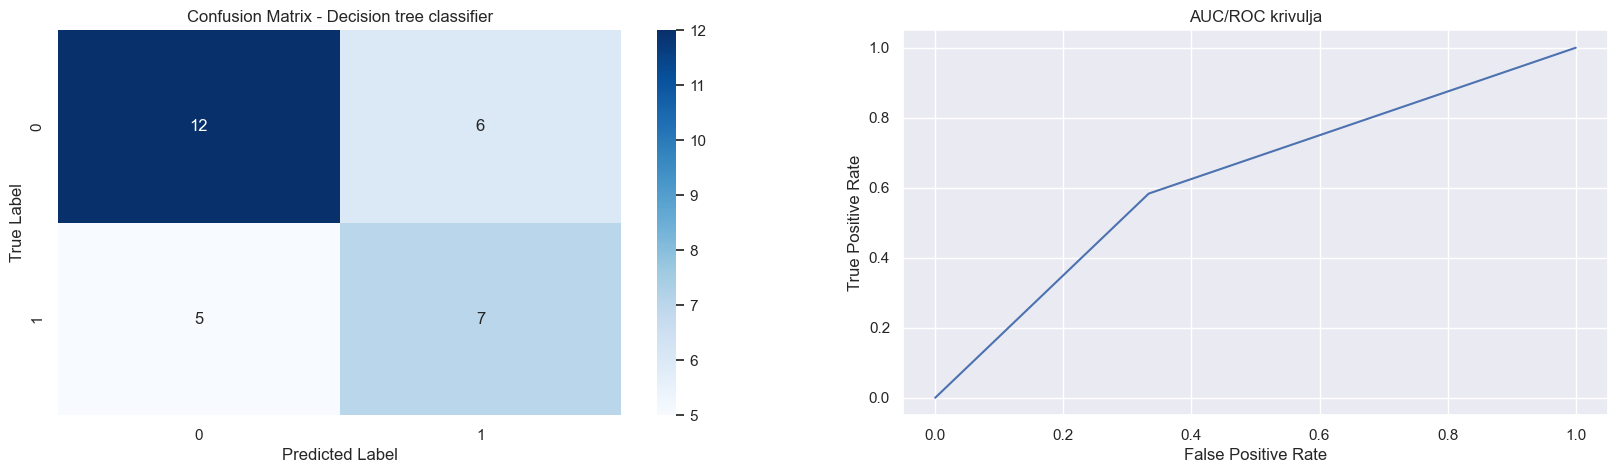

In [28]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(x_train, y_train)

decision_tree_predictins = decision_tree_model.predict(x_test)

print_scores(y_test, decision_tree_predictins, "Decision tree classifier")
print_graphs(y_test, decision_tree_predictins, decision_tree_model, "Decision tree classifier")

## RANDOM FOREST CLASSIFIER
Random forest je metoda koja kombinira više stabala odluke kako bi se poboljšala stabilnost i preciznost modela. Ovaj model obično smanjuje problem overfittinga, ali može izgubiti interpretabilnost jer se oslanja na veliki broj stabala. Random Forest se često koristi kada su podaci kompleksni i kada jednostavni modeli ne mogu dati zadovoljavajuće rezultate.

Testiranje preciznosti random forest classifier modela:


Evaluacija modela: Random forest classifier
-> Accuracy:  60.00%
-> Precision: 0.6125
-> Recall:    0.6000
-> F1 Score:  0.6036


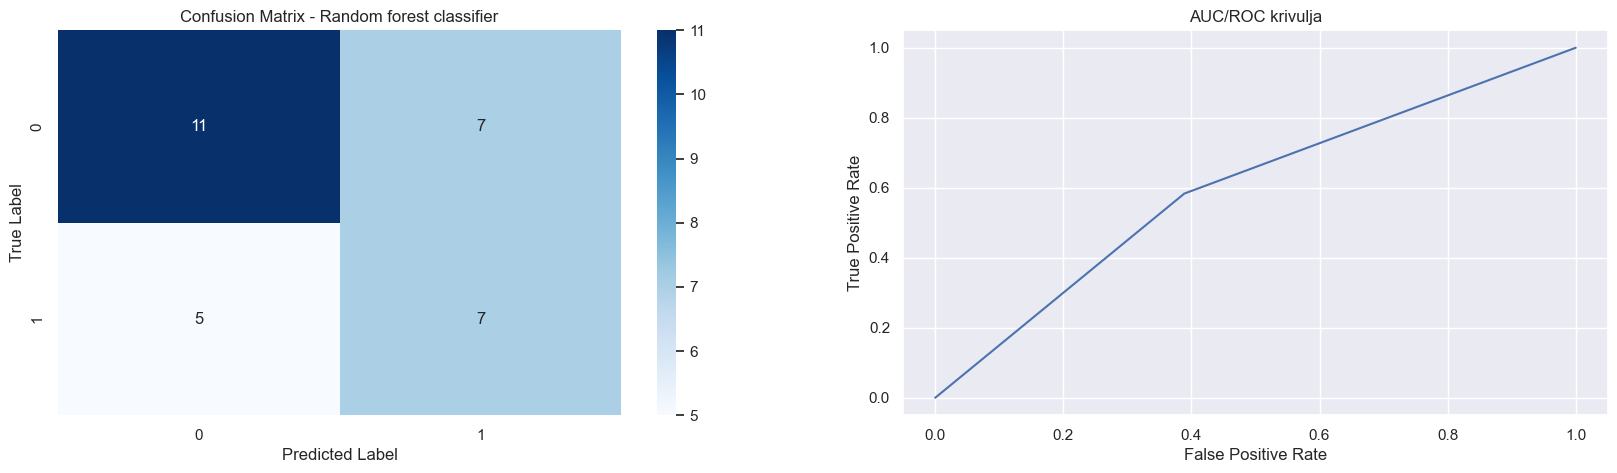

In [29]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(x_train, y_train)

random_forest_predictiones = random_forest_model.predict(x_test)

print_scores(y_test, random_forest_predictiones, "Random forest classifier")
print_graphs(y_test, random_forest_predictiones, random_forest_model, "Random forest classifier")

## SUPPORT VECTOR MACHINE
Support vector machine je snažan model za klasifikaciju koji je posebno efikasan u situacijama kada su podaci linearno separabilni ili kada se koriste kernel metode za nelinearne granice odlučivanja. SVM je često dobar izbor za male do srednje velike skupove podataka i može postići visoku točnost uz pravilno podešavanje hiperparametara.

Testiranje preciznosti support vector machine modela:




Evaluacija modela: Support vector machine
-> Accuracy:  66.67%
-> Precision: 0.6964
-> Recall:    0.6667
-> F1 Score:  0.6696


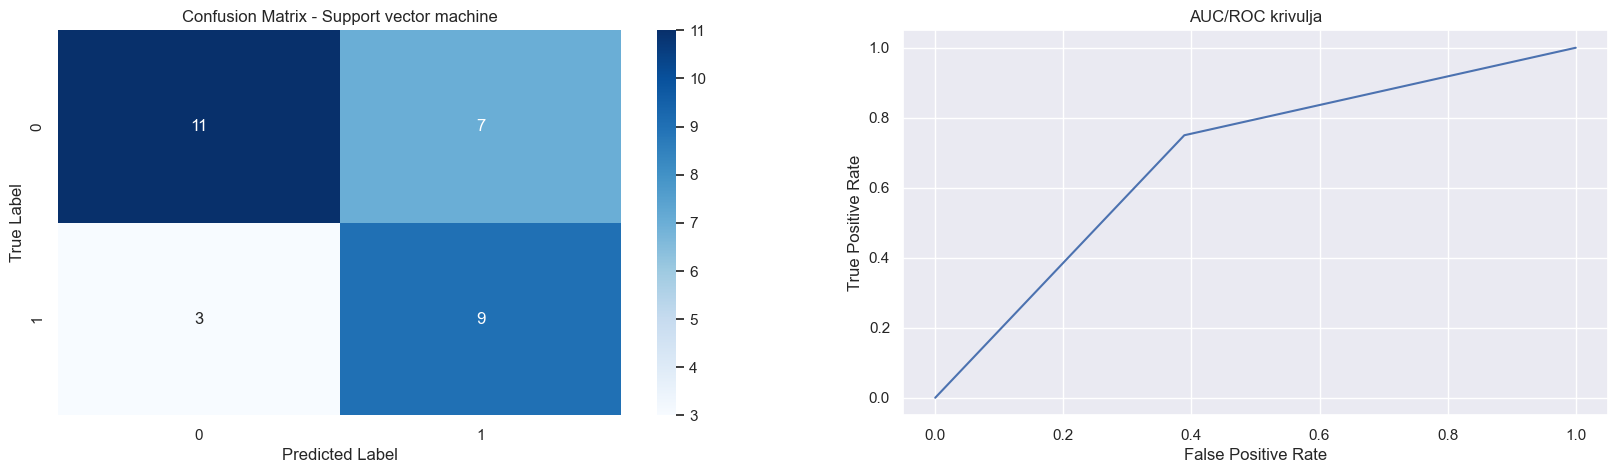

In [30]:
support_vector_machine = SVC(kernel='linear', probability=True)
support_vector_machine.fit(x_train, y_train)

support_vector_machine_predictions = support_vector_machine.predict(x_test)

print_scores(y_test, support_vector_machine_predictions, "Support vector machine")
print_graphs(y_test, support_vector_machine_predictions, support_vector_machine, "Support vector machine")

### XGBOOST
XGBoost je napredni boosting algoritam koji koristi sekvencijalno treniranje običnih stabala odluke kako bi poboljšao točnost modela. Poznat je po svojoj brzini i visokoj preciznosti, ali zahtijeva detaljno podešavanje hiperparametara kako bi se izbjegao overfitting. XGBoost je često jedan od najboljih izbora u natjecateljskom modeliranju kada su podaci kompleksni i veliki.

Testiranje preciznosti xgboost modela:


Evaluacija modela: XGBoost
-> Accuracy:  63.33%
-> Precision: 0.6533
-> Recall:    0.6333
-> F1 Score:  0.6370


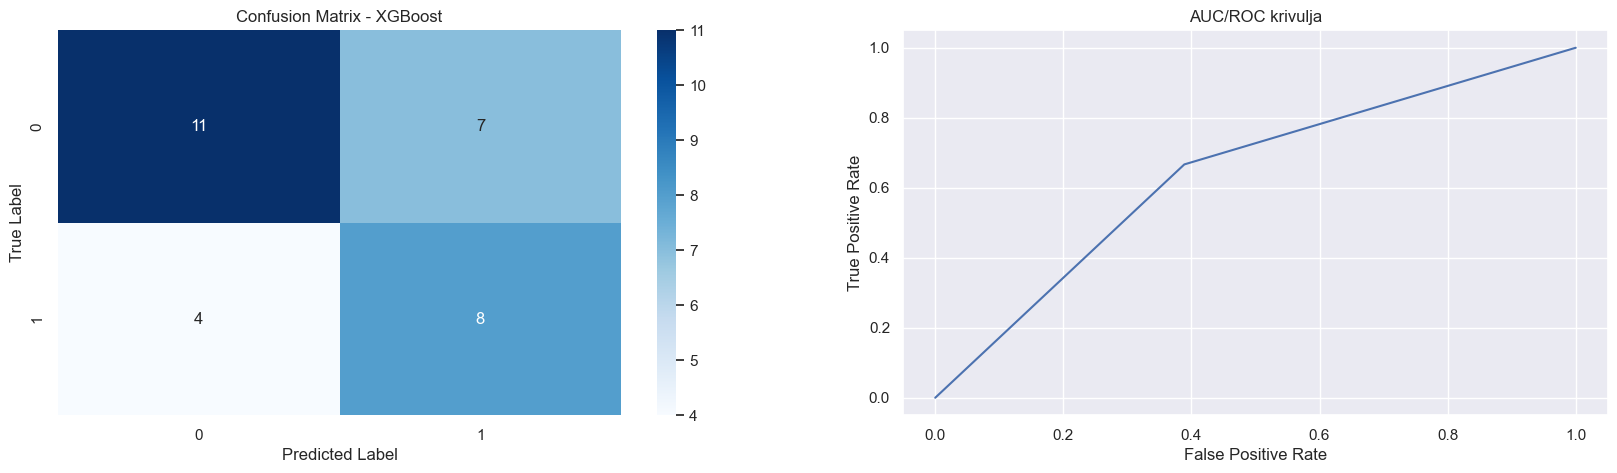

In [31]:
xgboost_model = XGBClassifier()
xgboost_model.fit(x_train, y_train)

xgboost_predictions = xgboost_model.predict(x_test)

print_scores(y_test, xgboost_predictions, "XGBoost")
print_graphs(y_test, xgboost_predictions, xgboost_model, "XGBoost")

## VOTING CLASSIFIER
Voting Classifier je model koji kombinira predikcije više različitih modela kako bi poboljšao ukupnu točnost. Postoje hard (svaki model predlaže jednu klasu kao konačnu predikciju.) i soft (svaki model vraća vjerovatnost pripadnosti nekoj klasi umjesto samo diskretne klase (0 ili 1)) verzije. Ovaj model može donijeti poboljšanja ako su korišteni modeli dovoljno različiti, ali ako svi modeli imaju slične greške, Voting Classifier neće dati značajno bolje rezultate.

Testiranje preciznosti voting classifier modela

In [ ]:
estimators = [('dt', decision_tree_model), ('svm', support_vector_machine), ('rf', random_forest_model), ('xgb', xgboost_model)]
voting_model = VotingClassifier(estimators = estimators, voting = 'soft')
voting_model.fit(x_train, y_train)

voting_pred = voting_model.predict(x_test)

print_scores(y_test, voting_pred, "Voting classifier")
print_graphs(y_test, voting_pred, voting_model, "Voting classifier")

## Pregled performansi pojedinih modela
U ovom poglavlju radimo analizu svih istreniranih modela i njihovih rezultata te ćemo ih međusobno usporediti.

                          Accuracy  Precision    Recall  F1-score
Decision tree classifier  0.666667   0.678571  0.666667  0.669683
Random forest classifier  0.633333   0.653333  0.633333  0.637037
Support vector machine    0.666667   0.696429  0.666667  0.669643
XGBoost                   0.633333   0.653333  0.633333  0.637037
Voting classifier         0.633333   0.638914  0.633333  0.635429



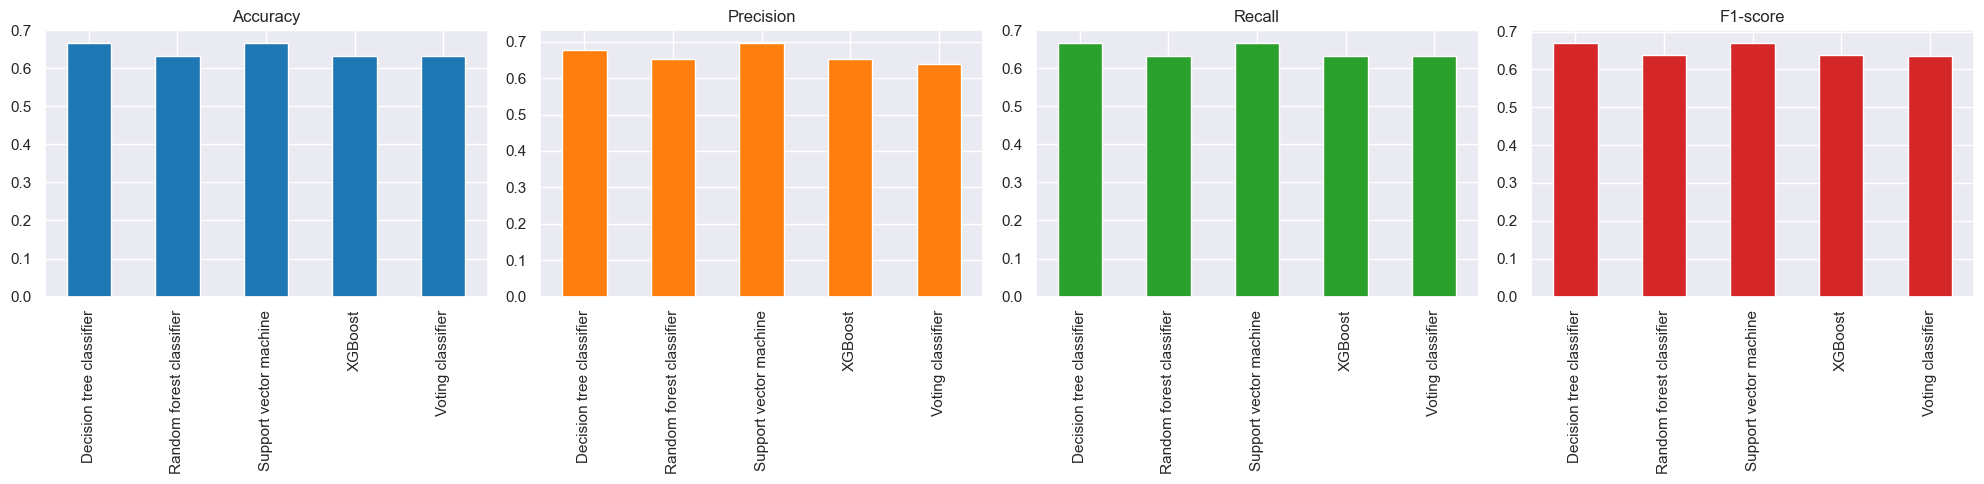

In [192]:
print("=================================================================")
print(df)
print("=================================================================\n")
num_cols = len(df.columns)
fig_, axes = plt.subplots(1, num_cols, figsize=(5 * num_cols, 5))
plot_colors = plt.get_cmap("tab10").colors

for i, (col, color) in enumerate(zip(df.columns, plot_colors)):
    df[col].plot(kind='bar', ax=axes[i], color=color)
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### Zaključak o modelima
#### 1. Decision tree classifier

Rezultati mjerenja:

- ovaj model postiže gotovo najbolje performanse s najvišim F1-scoreom (~0.67) i accuracy metrikom

#### 2. Random forest classifier

Rezultati mjerenja:

- budući da ovaj model kombinira više modela kako bi se poboljšali rezultati -> ovdje to nije bio vidljivi slučaj što nam može sugerirati da su podaci relativno jednostavni i da u tim slučajevima kompleksniji modeli ne donose nužno dodatna poboljšanja

#### 3. Support vector machine

Rezultati mjerenja:

- support vector machine postiže najbolju preciznost i F1-score -> ovaj model je dobar izbor jer izbjegava lažno pozitivne klasifikacije, dok istovremeno točno prepoznaje većinu pozitivnih primjera

#### 4.XGBoost

Rezultati mjerenja:

- budući da ovaj model kao i random forest classifier kombinira više modela u cilju poboljšanja rezultata -> ovdje to također nije bio slučaj što nam opet govori da kompleksniji modeli za ovaj problem nisu najprikladniji odabir

#### 5. Voting classifier

Rezultati mjerenja:

- s obzirom na način rada voting classifiera i njegovih rezultata -> zaključujemo da se korišteni modeli ne razlikuju dovoljno ili da metoda glasanja nije optimalno konfigurirana

